# Practice: Question Answering with a Fine-Tuned BERT (and TTS example)

This notebook is based on great [post and corresponding notebook](https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/) *by Chris McCormick*. It contains some minor changes and additions (especially parts 3 and 4).

What does it mean for BERT to achieve "human-level performance on Question Answering"? Is BERT the greatest search engine ever, able to find the answer to any question we pose it?

In **Part 1** of this notebook, we will discuss what it really means to apply BERT to QA, and illustrate the details.

**Part 2** contains example code--we'll be downloading a model that's *already been fine-tuned* for question answering, and try it out on our own text! 

In **Part 3** we will apply the same approach to Russian language using the model pre-trained on SberQuAD dataset.

And in **Part 4** and **Part 5** we will generate question and answer as audio in english and russian languages.

**Links**

* The [video walkthrough](https://youtu.be/l8ZYCvgGu0o) on this topic. 
* The [original blog post](https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/) version.
* The [original Colab Notebook](https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-).

In [1]:
!pip install -U transformers deeppavlov unidecode omegaconf
!python -m deeppavlov install squad_ru_rubert

# Pre-downloading the BERT for Russian language. Same result can be achieved with
# `!python -m deeppavlov download squad_ru_rubert`
# But it works significantly slower.
!wget -nc https://www.dropbox.com/s/7za1o6vaffbdlcg/rubert_cased_L-12_H-768_A-12_v1.tar.gz
!mkdir -p /root/.deeppavlov/downloads/bert_models/
!tar -xzvf rubert_cased_L-12_H-768_A-12_v1.tar.gz -C /root/.deeppavlov/downloads/bert_models

!wget -nc https://www.dropbox.com/s/ns8280pd9t9n9dc/squad_model_ru_rubert.tar.gz
!mkdir -p /root/.deeppavlov/models/
!tar -xzvf squad_model_ru_rubert.tar.gz -C /root/.deeppavlov/models

2022-01-24 18:30:04.846 INFO in 'deeppavlov.core.common.file'['file'] at line 32: Interpreting 'squad_ru_rubert' as '/usr/local/lib/python3.7/dist-packages/deeppavlov/configs/squad/squad_ru_rubert.json'
  Cloning https://github.com/deepmipt/bert.git (to revision feat/multi_gpu) to /tmp/pip-req-build-51q_f2_a
  Running command git clone -q https://github.com/deepmipt/bert.git /tmp/pip-req-build-51q_f2_a
File ‘rubert_cased_L-12_H-768_A-12_v1.tar.gz’ already there; not retrieving.

rubert_cased_L-12_H-768_A-12_v1/
rubert_cased_L-12_H-768_A-12_v1/bert_config.json
rubert_cased_L-12_H-768_A-12_v1/vocab.txt
rubert_cased_L-12_H-768_A-12_v1/bert_model.ckpt.data-00000-of-00001
rubert_cased_L-12_H-768_A-12_v1/bert_model.ckpt.index
rubert_cased_L-12_H-768_A-12_v1/bert_model.ckpt.meta
File ‘squad_model_ru_rubert.tar.gz’ already there; not retrieving.

squad_ru_bert/
squad_ru_bert/model_rubert.data-00000-of-00001
squad_ru_bert/model_rubert.index
squad_ru_bert/model_rubert.meta


In [2]:
import torch


assert (
    torch.cuda.is_available()
), 'Tacotron2 by NVIDIA infers only on GPU, so the Part 4 will not work on CPU-only machine'

device = torch.device('cuda:0')
tacotron2 = torch.hub.load(
    'nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2', **{'map_location': device}
)
tacotron2.to(device)
tacotron2.eval()

waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow.to(device)
waveglow.eval();

Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub
/root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub
/root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The b

## Part 1: Applying BERT to Question Answering

### The SQuAD v1.1 Benchmark

When someone mentions "Question Answering" as an application of BERT, what they are really referring to is applying BERT to the Stanford Question Answering Dataset (SQuAD).

The task posed by the SQuAD benchmark is a little different than you might think. Given a question, and *a passage of text containing the answer* (often refered to as context), BERT needs to highlight the "span" of text corresponding to the correct answer. 

The SQuAD homepage has a fantastic tool for exploring the questions and reference text for this dataset, and even shows the predictions made by top-performing models.

For example, here are some [interesting examples](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Super_Bowl_50.html?model=r-net+%20(ensemble)%20(Microsoft%20Research%20Asia)&version=1.1) on the topic of Super Bowl 50.


### BERT Input Format

To feed a QA task into BERT, we pack both the question and the reference text into the input.

![Input format for QA](https://raw.githubusercontent.com/neychev/made_nlp_course/master/week10_speech_distillation_and_perspectives/img/input_formatting_image.png)
*Image credits: [Chris McCormick](https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/)*

The two pieces of text are separated by the special `[SEP]` token. 

> _Side note:_ Original BERT also uses "Segment Embeddings" to differentiate the question from the reference text. These are simply two embeddings (for segments "A" and "B") that BERT learned, and which it adds to the token embeddings before feeding them into the input layer. However today we will be using DistilBERT model, which relies solely on the special tokens.

### Start & End Token Classifiers

BERT needs to highlight a "span" of text containing the answer--this is represented as simply predicting which token marks the start of the answer, and which token marks the end.

![Start token classification](https://raw.githubusercontent.com/neychev/made_nlp_course/master/week10_speech_distillation_and_perspectives/img/start_token_classification_image.png)
*Image credits: [Chris McCormick](https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/)*

For every token in the text, we feed its final embedding into the start token classifier. The start token classifier only has a single set of weights (represented by the blue "start" rectangle in the above illustration) which it applies to every word.

After taking the dot product between the output embeddings and the 'start' weights, we apply the softmax activation to produce a probability distribution over all of the words. Whichever word has the highest probability of being the start token is the one that we pick.

We repeat this process for the end token--we have a separate weight vector this.

![End token classification](https://raw.githubusercontent.com/neychev/made_nlp_course/master/week10_speech_distillation_and_perspectives/img/end_token_classification_image.png)
*Image credits: [Chris McCormick](https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/)*

## Part 2: Example Code

In the example code below, we'll be downloading a model that's *already been fine-tuned* for question answering, and try it out on our own text.

If you do want to fine-tune on your own dataset, it is possible to fine-tune BERT for question answering yourself. See [run_squad.py](https://github.com/huggingface/transformers/blob/master/examples/run_squad.py) in the `transformers` library. However, you may find that the "fine-tuned-on-squad" model already does a good job, even if your text is from a different domain.

### 1. Load Fine-Tuned BERT

This example uses the `transformers` [library](https://github.com/huggingface/transformers/) by huggingface. We've already installed it in the top of this notebook.

For Question Answering we use the `DistilBertForQuestionAnswering` class from the `transformers` library.

This class supports fine-tuning, but for this example we will keep things simpler and load a BERT model that has already been fine-tuned for the SQuAD benchmark.

The `transformers` library has a large collection of pre-trained models which you can reference by name and load easily. The full list is in their documentation [here](https://huggingface.co/transformers/pretrained_models.html).

In [3]:
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizer


tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')

/usr/local/lib/python3.7/dist-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


> _Side note:_ Apparently the vocabulary of this model is identicaly to the one in bert-base-uncased. You can load the tokenizer from `bert-base-uncased` and that works just as well.

### 2. Ask a Question

Now we're ready to feed in an example!

A QA example consists of a question and a passage of text containing the answer to that question.

In [4]:
question = "How many parameters does BERT-large have?"
context = (
    "BERT-large is really big... it has 24-layers and an embedding size of 1,024, "
    "for a total of 340M parameters! Altogether it is 1.34GB, so expect it to "
    "take a couple minutes to download to your Colab instance."
)

We'll need to run the BERT tokenizer against both the `question` and the `context`. To feed these into BERT, we actually concatenate them together and place the special `[SEP]` token in between.


In [5]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer(question, context)["input_ids"]
print(f"The input has a total of {len(input_ids)} tokens.")

The input has a total of 70 tokens.


Just to see exactly what the tokenizer is doing, let's print out the tokens with their IDs.

In [6]:
# BERT only needs the token IDs, but for the purpose of inspecting the
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Display tokens and ids as table.
# For each token and its id...
for token, token_id in zip(tokens, input_ids):

    # If this is the [SEP] token, add some space around it to make it stand out.
    if token_id == tokenizer.sep_token_id:
        print()

    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, token_id))

    if token_id == tokenizer.sep_token_id:
        print()

[CLS]           101
how           2,129
many          2,116
parameters   11,709
does          2,515
bert         14,324
-             1,011
large         2,312
have          2,031
?             1,029

[SEP]           102

bert         14,324
-             1,011
large         2,312
is            2,003
really        2,428
big           2,502
.             1,012
.             1,012
.             1,012
it            2,009
has           2,038
24            2,484
-             1,011
layers        9,014
and           1,998
an            2,019
em            7,861
##bed         8,270
##ding        4,667
size          2,946
of            1,997
1             1,015
,             1,010
02            6,185
##4           2,549
,             1,010
for           2,005
a             1,037
total         2,561
of            1,997
340          16,029
##m           2,213
parameters   11,709
!               999
altogether   10,462
it            2,009
is            2,003
1             1,015
.             1,01

We're ready to feed our example into the model!



In [7]:
import torch


inputs = tokenizer(question, context, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)

start_scores = outputs.start_logits
end_scores = outputs.end_logits
start_scores

tensor([[-4.6549, -5.4920, -6.9543, -6.7978, -7.1190, -6.0274, -7.6631, -7.2082,
         -7.0247, -7.7690, -5.1297, -0.3305, -5.2058, -3.4652, -5.0982, -3.6160,
         -3.1994, -5.3622, -4.9089, -4.3704,  0.1852, -3.1188,  0.8591, -4.5655,
         -3.5403, -5.3101, -2.1212, -2.7155, -5.5414, -5.5158, -3.3945, -4.0354,
          3.2313, -3.4973, -3.2838, -3.3052, -5.1053,  0.2443,  2.3932,  2.4217,
         -1.7133,  8.3842, -0.9214, -2.0461, -3.8585, -0.5486, -2.0815, -5.2040,
         -0.2521, -4.4770, -1.9723, -4.0387, -5.5288, -5.0099, -5.4694, -5.3426,
         -6.2675, -5.2602, -4.2696, -3.3130, -5.1041, -6.8950, -4.9450, -7.1310,
         -6.1638, -4.3083, -6.5881, -5.6170, -6.0569, -5.1298]])

Now we can highlight the answer just by looking at the most probable start and end words. 

In [8]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start : answer_end + 1])

print(f'Answer: "{answer}"')

Answer: "340 ##m"


It got it right! Awesome :)

> *Side Note: It's a little naive to pick the highest scores for start and end--what if it predicts an end word that's before the start word?! The correct implementation is to pick the highest total score for which end >= start.*

With a little more effort, we can reconstruct any words that got broken down into subwords.

In [9]:
answer = tokenizer.decode(input_ids[answer_start : answer_end + 1])
print(f'Answer: "{answer}"')

Answer: "340m"


### 3. Visualizing Scores

Let's see what the scores were for all of the words. The following cells generate bar plots showing the start and end scores for every word in the input.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 16

Retrieve all of the start and end scores, and use all of the tokens as x-axis labels.

In [11]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
start_scores = start_scores.numpy().flatten()
end_scores = end_scores.numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

Create a bar plot showing the score for every input word being the "start" word.

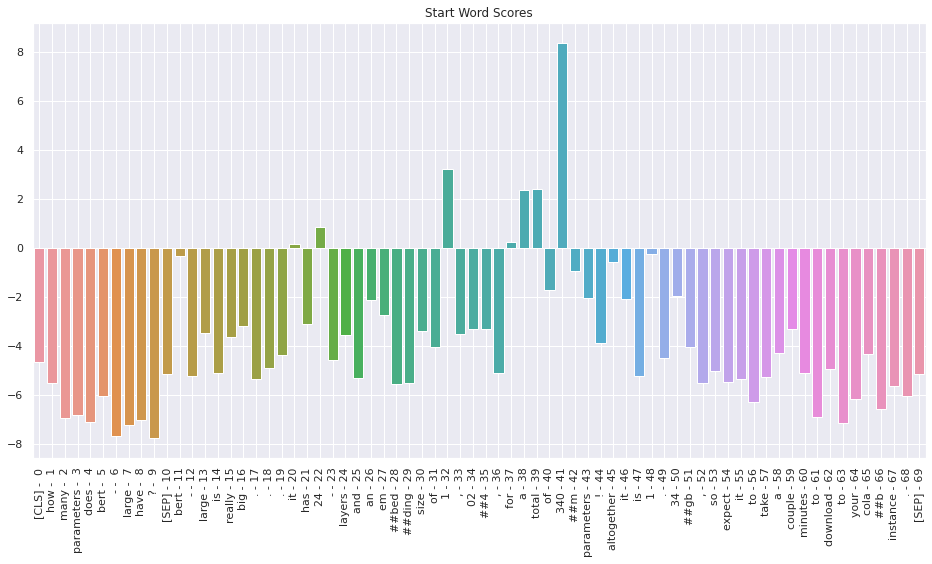

In [12]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=start_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores');

Create a second bar plot showing the score for every input word being the "end" word.

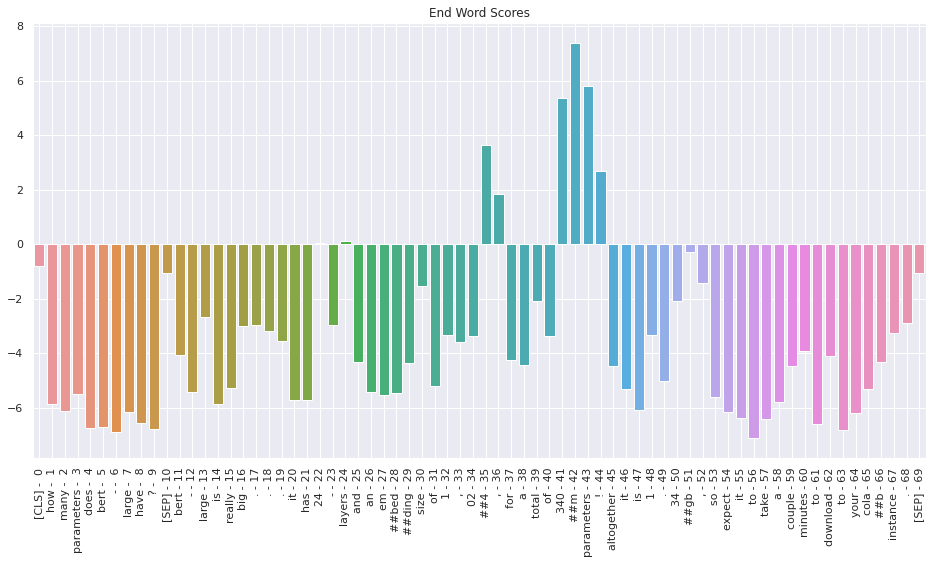

In [13]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=end_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores');

**Alternate View**

I also tried visualizing both the start and end scores on a single bar plot, but I think it may actually be more confusing then seeing them separately. 

In [14]:
import pandas as pd


# Store the tokens and scores in a DataFrame.
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 'score': start_scores[i], 'marker': 'start'})

    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 'score': end_scores[i], 'marker': 'end'})

df = pd.DataFrame(scores)

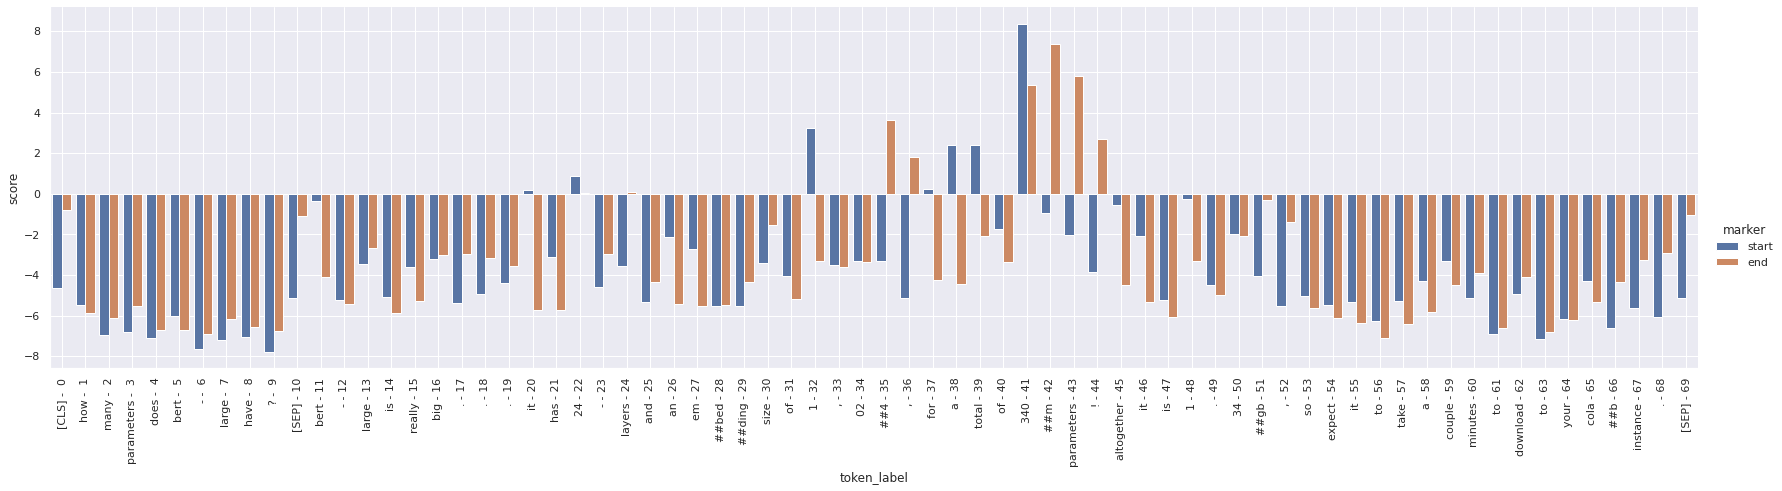

In [15]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
plot = sns.catplot(
    x="token_label", y="score", hue="marker", data=df, kind="bar", height=6, aspect=4
)

# Turn the xlabels vertical.
plot.set_xticklabels(plot.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
plot.ax.grid(True);

### 4. More Examples

Turn the QA process into a function so we can easily try out other examples.

In [16]:
def answer_question(question, context):
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    inputs = tokenizer(question, context, return_tensors='pt')
    input_ids = inputs["input_ids"].numpy().squeeze()

    # ======== Evaluate ========
    # Run our example question through the model.
    outputs = model(**inputs)
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    token_ids = input_ids[answer_start : answer_end + 1]
    answer = tokenizer.decode(token_ids)

    return answer

As our reference text, we've taken the Abstract of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf).


In [17]:
bert_abstract = (
    'We introduce a new language representation model called BERT, which stands for '
    'Bidirectional Encoder Representations from Transformers. Unlike recent language '
    'representation models (Peters et al., 2018a; Radford et al., 2018), BERT is '
    'designed to pretrain deep bidirectional representations from unlabeled text by '
    'jointly conditioning on both left and right context in all layers. As a result, '
    'the pre-trained BERT model can be finetuned with just one additional output '
    'layer to create state-of-the-art models for a wide range of tasks, such as '
    'question answering and language inference, without substantial taskspecific '
    'architecture modifications. BERT is conceptually simple and empirically '
    'powerful. It obtains new state-of-the-art results on eleven natural language '
    'processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute '
    'improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 '
    'question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD '
    'v2.0 Test F1 to 83.1 (5.1 point absolute improvement).'
)

Let's ask BERT what its name stands for (the answer is in the first sentence of the abstract).

In [18]:
question = "What does the 'B' in BERT stand for?"
answer = answer_question(question, bert_abstract)
print(f'Answer: "{answer}"')

Answer: "bidirectional encoder representations from transformers"


Let's ask BERT about example applications of itself :)

The answer to the question comes from this passage from the abstract: 

> "...BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for **a wide range of tasks, such as
question answering and language inference,** without substantial taskspecific
architecture modifications."

In [19]:
question = "What are some example applications of BERT?"
answer = answer_question(question, bert_abstract)
print(f'Answer: "{answer}"')

Answer: "question answering and language inference"


## Part 3. RuBERT for question answering.

Here we will use the model pre-trained on the SberQuAD dataset from the [SDSJ-2017 challenge problem B](https://github.com/sberbank-ai/data-science-journey-2017/tree/master/problem_B).

In [20]:
from deeppavlov import build_model, configs


model_ru = build_model(configs.squad.squad_ru_rubert, download=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!












The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.





Instructions for updating:
Use standard file APIs to check for files with this prefix.


2022-01-24 18:31:35.100 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /root/.deeppavlov/models/squad_ru_bert/model_rubert]



INFO:tensorflow:Restoring parameters from /root/.deeppavlov/models/squad_ru_bert/model_rubert


The following text is copied from [habr post on Crew Dragon flight](https://habr.com/ru/news/t/504642/).

In [21]:
context = (
    'Первая многоразовая ступень ракеты-носителя Falcon 9 успешно отделилась через две с половиной '
    'минуты после старта и автоматически приземлилась на плавучую платформу Of Course I Still '
    'Love You у берегов Флориды. Через 12 минут после запуска космический корабль Crew Dragon '
    'вышел на расчетную орбиту и отделился от второй ступени ракеты.'
    '\n\n'
    'Сближение корабля Crew Dragon с Международной космической станцией запланировано на 31 мая. '
    'К стыковочному адаптеру на узловом модуле «Гармония» американского сегмента МКС Crew Dragon '
    'должен причалить в ручном или, при необходимости, в автоматическом режиме. Эта процедура '
    'запланирована на 10:29 по времени Восточного побережья США (17:29 по московскому времени).'
    '\n\n'
    'В испытательном полете DM2 астронавт Херли является командиром космического корабля (spacecraft '
    'commander), а его напарник Бенкен — командир по операциям стыковки и расстыковки (joint '
    'operations commander). Фактически это означает, что именно Херли управляет Crew Dragon в '
    'полете к МКС, к которой они должны пристыковаться в течение суток после старта. Херли и Бенкен '
    'также будут выполнять необходимые для сертификации НАСА проверки систем корабля в полете.'
    '\n\n'
    'Во время полета Херли и Бенкен провели небольшую экскурсию по Crew Dragon.'
)

And here is how to use deeppavlov's model:

In [22]:
question = 'Когда отделилась первая ступень?'
model_ru([context], [question])

[['через две с половиной минуты после старта'], [72], [2055727.625]]

The model returns list with answer, answer starting position in context and the answer logit.

This yields the following `answer_question` function.

In [23]:
def answer_question_ru(question, context):
    output = model_ru([context], [question])
    return output[0][0]

Let's ask a bunch of other questions to the model.

In [24]:
question = 'На какую дату запланирована стыковка?'
answer = answer_question_ru(question, context)
print(f'Ответ: "{answer}"')

Ответ: "на 31 мая"


In [25]:
question = 'Кто участвует в полете?'
answer = answer_question_ru(question, context)
print(f'Ответ: "{answer}"')

Ответ: "астронавт Херли"


In [26]:
question = 'Кто участвует в полете кроме астронавта Херли?'
answer = answer_question_ru(question, context)
print(f'Ответ: "{answer}"')

Ответ: "Бенкен"


In [27]:
question = 'Какие астронавты участвовали в полете?'
answer = answer_question_ru(question, context)

# Notice how model finds the appropriate answer dispite slightly different context.
print(f'Ответ: "{answer}"')

Ответ: "Херли и Бенкен"


In [28]:
question = 'Какая ступень приземлилась на плавучую платформу Of Course I Still Love You?'
answer = answer_question_ru(question, context)
print(f'Ответ: "{answer}"')

Ответ: "Первая многоразовая ступень ракеты-носителя Falcon 9"


## Part 4. Question answering with speech using Tacotron 2.

### Text to speech using Tacotron 2.

Tacotron 2 is a network proposed in 2017 in [Natural TTS Synthesis By Conditioning
Wavenet On Mel Spectrogram Predictions](https://arxiv.org/pdf/1712.05884.pdf) paper. This network takes an input text and maps it into the mel-frequency spectrogram. This spectrogram is then passed through a modified WaveNet (generative model for audio, original paper can be found [here](https://arxiv.org/pdf/1609.03499.pdf)) to generate the actual speech.

Let's look more closely at a mel spectrogram (for more info on its nature please refer to the [Tacotron 2 paper](https://arxiv.org/pdf/1712.05884.pdf)).

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


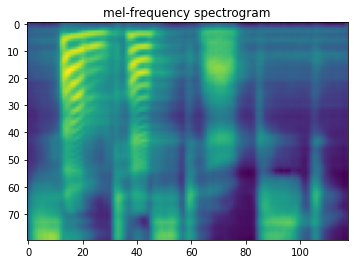

In [29]:
assert (
    tacotron2 is not None and waveglow is not None
), 'Tacotron2 by NVIDIA infers only on GPU, so the Part 4 will not work on CPU-only machine'
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

text = 'Some test text.'
sequences, lengths = utils.prepare_input_sequence([text])
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)

sns.reset_orig()
plt.imshow(mel[0].cpu().numpy())
plt.title('mel-frequency spectrogram');

After obtaining this spectrogram, we can generate the audio with `waveglow` model.

In [30]:
from IPython.display import Audio


sampling_rate = 22050

with torch.no_grad():
    audio = waveglow.infer(mel)

audio_numpy = audio[0].cpu().numpy()
Audio(audio_numpy, rate=sampling_rate)

We've generated a `.wav` format audio. We can save it using the `scipy.io.wavfile.write`.

In [31]:
from scipy.io.wavfile import write


write('audio.wav', sampling_rate, audio_numpy)

This yields the following `text_to_speech` function.

In [32]:
def text_to_speech(text):
    # preprocessing
    sequences, lengths = utils.prepare_input_sequence([text])

    # run the models
    with torch.no_grad():
        mel, _, _ = tacotron2.infer(sequences, lengths)
        audio = waveglow.infer(mel)

    audio_numpy = audio[0].cpu().numpy()
    return audio_numpy

In [33]:
text = 'Another test text.'
audio_numpy = text_to_speech(text)
Audio(audio_numpy, rate=sampling_rate)

### Tying text to speech with question answering.

Let's take a look at [Mail.ru group blog post on Computer Vision on habr.com](https://habr.com/ru/company/mailru/blog/467905/)

In [34]:
context = (
    'One of Mail.ru Cloud’s objectives is to provide the handiest means for accessing '
    'and searching your own photo and video archives. For this purpose, we at Mail.ru '
    'Computer Vision Team have created and implemented systems for smart image '
    'processing: search by object, by scene, by face, etc. Another spectacular '
    'technology is landmark recognition. Today, I am going to tell you how we made '
    'this a reality using Deep Learning.'
    '\n\n'
    'Imagine the situation: you return from your vacation with a load of photos. Talking '
    'to your friends, you are asked to show a picture of a place worth seeing, like '
    'palace, castle, pyramid, temple, lake, waterfall, mountain, and so on. You rush to '
    'scroll your gallery folder trying to find one that is really good. Most likely, it '
    'is lost amongst hundreds of images, and you say you will show it later.'
    '\n\n'
    'We solve this problem by grouping user photos in albums. This will let you find '
    'pictures you need just in few clicks. Now we have albums compiled by face, by '
    'object and by scene, and also by landmark.'
    '\n\n'
    'Photos with landmarks are essential because they often capture highlights of our '
    'lives (journeys, for example). These can be pictures with some architecture or '
    'wilderness in the background. This is why we seek to locate such images and make '
    'them readily available to users.'
)

In [35]:
question = 'Why photos with landmarks are essential?'
answer = answer_question(question, context)
print(f'Answer: "{answer}"')

Answer: "because they often capture highlights of our lives"


Let's cat question and answer into one phrase and convert it to audio!

In [36]:
text = f'{question}\n{answer}'
audio_numpy = text_to_speech(text)
Audio(audio_numpy, rate=sampling_rate)

And another one.

In [37]:
question = "Which places except mountain are worth seeing?"
answer = answer_question(question, context)
print(f'Answer: "{answer}"')

text = f'{question}\n{answer}'
audio_numpy = text_to_speech(text)
Audio(audio_numpy, rate=sampling_rate)

Answer: "palace, castle, pyramid, temple, lake, waterfall"


In [38]:
# Take your time, experiment with questions and the generated audio

# 5. Russian langugage speech generation

Of course, text to speech is not specific to english language. Here is how you can do it with russian.

In [39]:
from omegaconf import OmegaConf


torch.hub.download_url_to_file(
    'https://raw.githubusercontent.com/snakers4/silero-models/master/models.yml',
    'latest_silero_models.yml',
    progress=False,
)
models = OmegaConf.load('latest_silero_models.yml')

# see latest avaiable models
available_languages = list(models['tts_models'].keys())
print(f'Available languages {available_languages}')

for lang in available_languages:
    speakers = list(models['tts_models'][lang].keys())
    print(f'Available speakers for {lang}: {speakers}')

Available languages ['ru', 'en', 'de', 'es', 'fr', 'ba', 'xal', 'tt', 'uz', 'ua', 'multi']
Available speakers for ru: ['aidar_v2', 'aidar_8khz', 'aidar_16khz', 'baya_v2', 'baya_8khz', 'baya_16khz', 'irina_v2', 'irina_8khz', 'irina_16khz', 'kseniya_v2', 'kseniya_8khz', 'kseniya_16khz', 'natasha_v2', 'natasha_8khz', 'natasha_16khz', 'ruslan_v2', 'ruslan_8khz', 'ruslan_16khz']
Available speakers for en: ['lj_v2', 'lj_8khz', 'lj_16khz']
Available speakers for de: ['thorsten_v2', 'thorsten_8khz', 'thorsten_16khz']
Available speakers for es: ['tux_v2', 'tux_8khz', 'tux_16khz']
Available speakers for fr: ['gilles_v2', 'gilles_8khz', 'gilles_16khz']
Available speakers for ba: ['aigul_v2']
Available speakers for xal: ['erdni_v2']
Available speakers for tt: ['dilyara_v2']
Available speakers for uz: ['dilnavoz_v2']
Available speakers for ua: ['mykyta_v2']
Available speakers for multi: ['multi_v2']


Let's choose our language and speaker and try using them!

In [40]:
language = 'ru'
speaker = 'kseniya_16khz'
device = torch.device('cpu')
model, symbols, sample_rate, example_text, apply_tts = torch.hub.load(
    'snakers4/silero-models', 'silero_tts', language=language, speaker=speaker
)
model = model.to(device)


audio = apply_tts(
    texts=[example_text], model=model, sample_rate=sample_rate, symbols=symbols, device=device
)

print(example_text)
Audio(audio[0], rate=sample_rate)

Using cache found in /root/.cache/torch/hub/snakers4_silero-models_master


В н+едрах т+ундры в+ыдры в г+етрах т+ырят в в+ёдра +ядра к+едров.


In [41]:
audio = apply_tts(
    texts=["Дерзайте знать! Спасибо за внимание!"],
    model=model,
    sample_rate=sample_rate,
    symbols=symbols,
    device=device,
)
Audio(audio[0], rate=sample_rate)